如果只需要预测新数据,不训练模型,仅运行带*的行即可

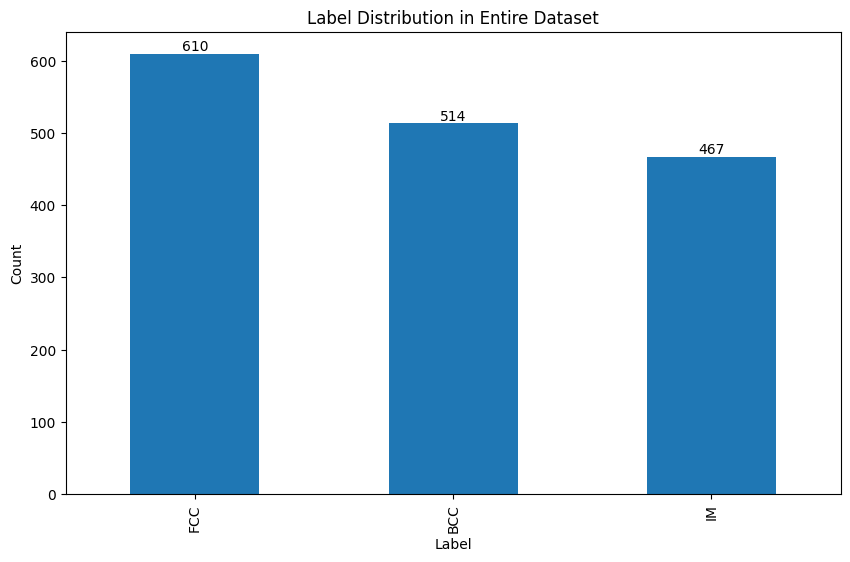

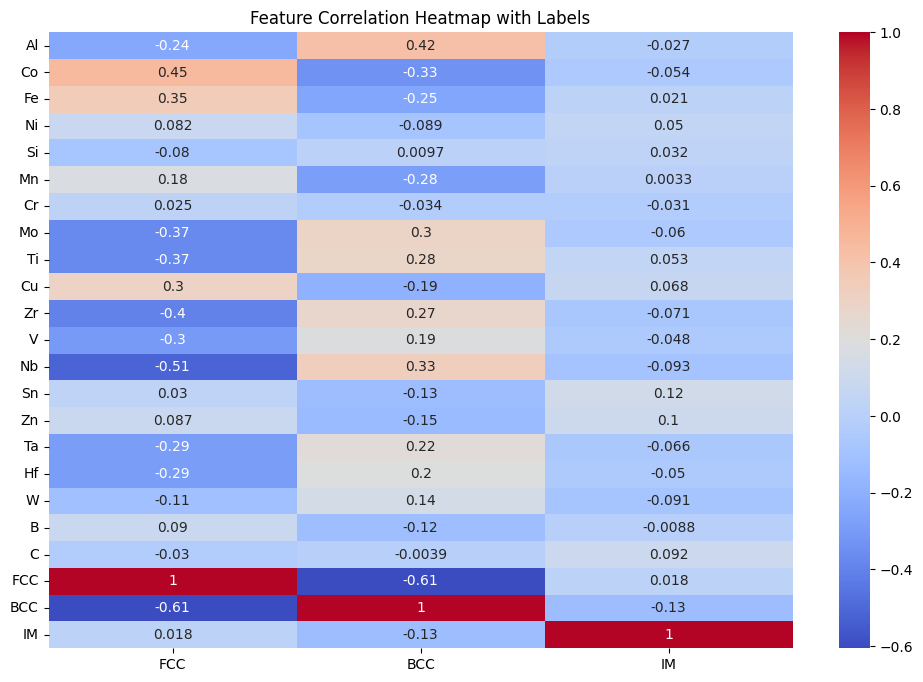


=== Fold 1 ===
Early stopping at epoch 201

=== Fold 2 ===
Early stopping at epoch 323

=== Fold 3 ===
Early stopping at epoch 69

=== Fold 4 ===
Early stopping at epoch 200

=== Fold 5 ===
Early stopping at epoch 202


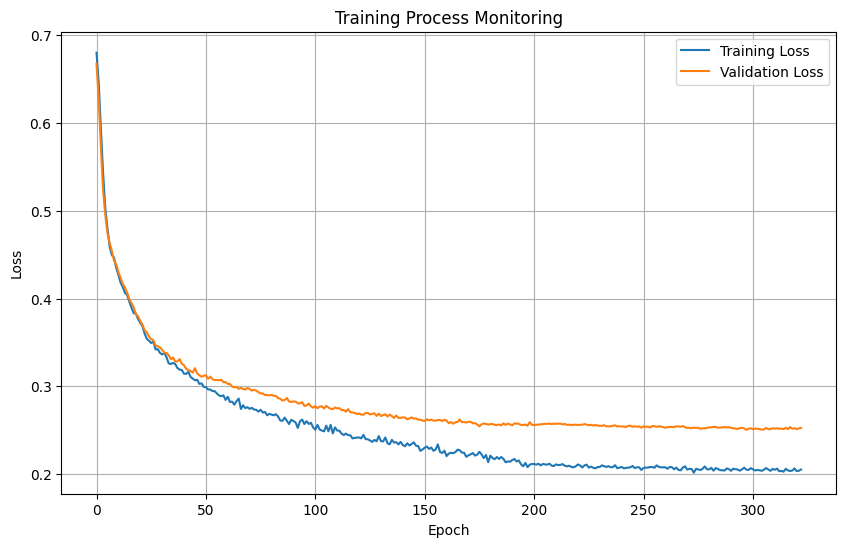

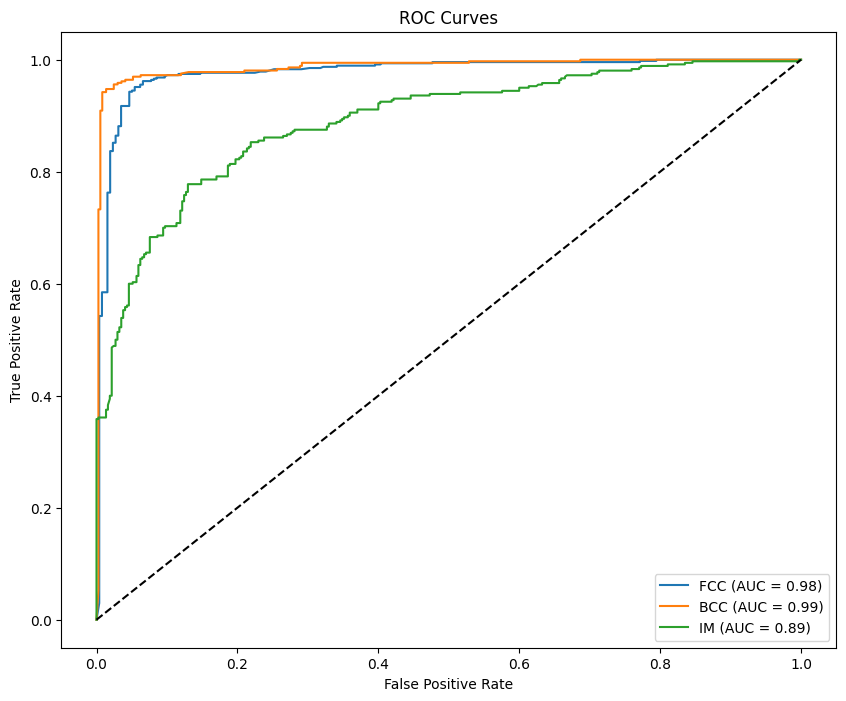

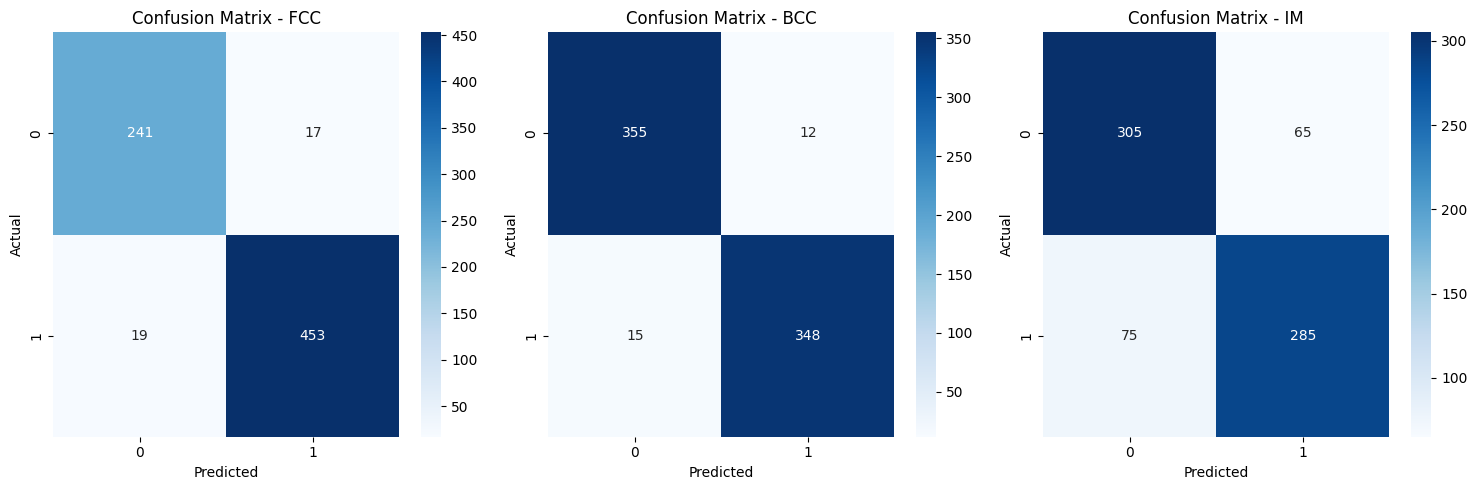

Final Evaluation Results:
Hamming Loss: 0.09269406392694064
              precision    recall  f1-score   support

         FCC       0.96      0.96      0.96       472
         BCC       0.97      0.96      0.96       363
          IM       0.81      0.79      0.80       360

   micro avg       0.92      0.91      0.91      1195
   macro avg       0.91      0.90      0.91      1195
weighted avg       0.92      0.91      0.91      1195
 samples avg       0.93      0.92      0.91      1195



c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import hamming_loss, classification_report, roc_curve, auc, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 数据加载和预处理
with open("Phase_data_plus.csv","r",encoding="utf-8") as f:
    df = pd.read_csv(f)

# 标签分布直方图
plt.figure(figsize=(10, 6))
label_counts = df[["FCC", "BCC", "IM"]].sum()
label_counts.plot(kind='bar')
plt.title("Label Distribution in Entire Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
for i, v in enumerate(label_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 2. 特征与标签相关性热力图
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix[["FCC", "BCC", "IM"]], annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap with Labels")
plt.show()

# 3. 神经网络模型定义
class PhaseClassifier(nn.Module):
    def __init__(self, input_size):
        super(PhaseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(64, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.sigmoid(self.out(x))

# 4. 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=500, patience=25):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    return train_losses, val_losses

# 5. 5折交叉验证
X = df.drop(["FCC", "BCC", "IM"], axis=1).values
y = df[["FCC", "BCC", "IM"]].values

all_train_loss = []
all_val_loss = []
all_test_preds = []
all_test_probs = []
all_test_true = []

for fold in range(5):
    print(f"\n=== Fold {fold+1} ===")
    
    # 数据划分
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=fold)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=fold)
    
    # 标准化
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # 转换为Tensor
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # 初始化模型
    model = PhaseClassifier(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    
    # 测试集预测
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    y_probs, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_probs.extend(outputs.numpy())
            y_true.extend(labels.numpy())
    all_test_probs.extend(y_probs)
    all_test_true.extend(y_true)
    all_test_preds.extend((np.array(y_probs) > 0.5).astype(int))

# 6. 训练过程监控图
max_length = max(len(loss) for loss in all_train_loss)
train_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_train_loss])
val_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_val_loss])

plt.figure(figsize=(10,6))
plt.plot(np.mean(train_matrix, axis=0), label='Training Loss')
plt.plot(np.mean(val_matrix, axis=0), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Process Monitoring')
plt.legend()
plt.grid(True)
plt.show()

# 7. ROC曲线
plt.figure(figsize=(10,8))
for i in range(3):
    fpr, tpr, _ = roc_curve(np.array(all_test_true)[:,i], np.array(all_test_probs)[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{["FCC", "BCC", "IM"][i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# 8. 多标签混淆矩阵
cm = multilabel_confusion_matrix(all_test_true, all_test_preds)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, (matrix, ax) in enumerate(zip(cm, axes)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {["FCC", "BCC", "IM"][i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# 9. 输出评估结果
print("Final Evaluation Results:")
print("Hamming Loss:", hamming_loss(all_test_true, all_test_preds))
print(classification_report(all_test_true, all_test_preds, target_names=["FCC", "BCC", "IM"]))

交叉验证，评估模型性能和泛化能力

In [ ]:
新版 有早停

*1

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import hamming_loss, classification_report, roc_curve, auc, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib


初始数据集

*2

In [9]:

# 创建目录保存结果
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results/training_curves", exist_ok=True)

# 1. 数据加载和预处理
print("Loading and preprocessing data...")
with open("Phase_data_plus.csv", "r", encoding="utf-8") as f:
    df = pd.read_csv(f)

# 特征和标签分离
features = df.drop(["FCC", "BCC", "IM"], axis=1)
labels = df[["FCC", "BCC", "IM"]]
feature_names = features.columns.tolist()

# 标签分布直方图
plt.figure(figsize=(10, 6))
label_counts = labels.sum()
label_counts.plot(kind='bar')
plt.title("Label Distribution in Entire Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
for i, v in enumerate(label_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.savefig("results/label_distribution.png")
plt.close()

# 2. 特征与标签相关性热力图
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix[["FCC", "BCC", "IM"]], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap with Labels")
plt.savefig("results/correlation_heatmap.png")
plt.close()


Loading and preprocessing data...


*3

In [10]:

# 3. 神经网络模型定义
class PhaseClassifier(nn.Module):
    def __init__(self, input_size):
        super(PhaseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(64, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        return self.sigmoid(self.out(x))


In [ ]:

# 4. 训练函数（添加损失记录和早停恢复）
def train_model(model, train_loader, val_loader, criterion, optimizer, device, fold, epochs=300, patience=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_epoch = 0
    no_improve = 0
    
    # 创建图表
    plt.figure(figsize=(12, 10))
    
    for epoch in range(epochs):
        start_time = time.time()
        # Training
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # 计算训练准确率
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == labels).all(dim=1).sum().item()
            total_train += labels.size(0)
            
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                # 计算验证准确率
                predicted = (outputs > 0.5).float()
                correct_val += (predicted == labels).all(dim=1).sum().item()
                total_val += labels.size(0)
                
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_accuracy
            best_epoch = epoch
            no_improve = 0
            torch.save(model.state_dict(), f'models/best_model_fold{fold}.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        epoch_time = time.time() - start_time
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
    
    # 绘制每个fold的训练曲线
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"results/training_curves/fold_{fold}_training.png")
    plt.close()
    
    # 保存每折的训练过程数据
    training_data = pd.DataFrame({
        'epoch': range(1, len(train_losses)+1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    })
    training_data.to_csv(f"results/training_curves/fold_{fold}_training_data.csv", index=False)
    
    return train_losses, val_losses, train_accuracies, val_accuracies, best_epoch

# 5. 10折交叉验证
print("\nStarting 10-fold cross-validation...")
X = features.values
y = labels.values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []
all_test_preds = []
all_test_probs = []
all_test_true = []
all_X_test_folds = []
all_y_test_folds = []
fold_results = []
feature_importances = []

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X)):
    fold_start = time.time()
    print(f"\n=== Fold {fold+1} ===")
    
    # 数据划分
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    
    # 添加测试集数据到列表用于特征重要性分析
    all_X_test_folds.append(X_test)
    all_y_test_folds.append(y_test)
    
    # 训练验证集再划分
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=1/9, random_state=42
    )
    
    # 标准化
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # 转换为Tensor
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    batch_size = 64 if device.type == 'cuda' else 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # 初始化模型
    model = PhaseClassifier(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # 训练
    train_loss, val_loss, train_acc, val_acc, best_epoch = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, fold+1
    )
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)
    
    # 测试集预测
    model.load_state_dict(torch.load(f'models/best_model_fold{fold+1}.pth'))
    model.eval()
    y_probs, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    y_pred = (np.array(y_probs) > 0.5).astype(int)
    
    # 存储当前fold的测试结果
    all_test_probs.extend(y_probs)
    all_test_true.extend(y_true)
    all_test_preds.extend(y_pred)
    
    # 计算并存储当前fold的指标
    fold_hamming = hamming_loss(y_true, y_pred)
    fold_report = classification_report(y_true, y_pred, target_names=["FCC", "BCC", "IM"], output_dict=True)
    fold_results.append({
        "fold": fold+1,
        "best_epoch": best_epoch,
        "final_train_loss": train_loss[-1] if train_loss else float('nan'),
        "final_val_loss": val_loss[-1] if val_loss else float('nan'),
        "final_train_acc": train_acc[-1] if train_acc else float('nan'),
        "final_val_acc": val_acc[-1] if val_acc else float('nan'),
        "hamming_loss": fold_hamming,
        "accuracy": fold_report["micro avg"]["precision"],
        "f1_weighted": fold_report["weighted avg"]["f1-score"]
    })
    
    # 打印当前fold结果
    print(f"\nFold {fold+1} Results:")
    print(f"Best Epoch: {best_epoch}")
    print(f"Final Train Loss: {train_loss[-1]:.5f}, Val Loss: {val_loss[-1]:.5f}")
    print(f"Final Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    print(f"Hamming Loss: {fold_hamming:.4f}")
    print(f"Accuracy: {fold_report["micro avg"]["precision"]:.4f}")
    print(classification_report(y_true, y_pred, target_names=["FCC", "BCC", "IM"]))
    
    fold_time = time.time() - fold_start
    print(f"Fold {fold+1} completed in {fold_time:.2f} seconds")

# 6. 综合训练过程监控图
max_length = max(len(loss) for loss in all_train_loss)

# 创建对齐的损失矩阵
train_loss_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_train_loss])
val_loss_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_val_loss])
train_acc_matrix = np.array([acc + [acc[-1]]*(max_length-len(acc)) for acc in all_train_acc])
val_acc_matrix = np.array([acc + [acc[-1]]*(max_length-len(acc)) for acc in all_val_acc])

# 损失曲线
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
mean_train_loss = np.mean(train_loss_matrix, axis=0)
mean_val_loss = np.mean(val_loss_matrix, axis=0)

plt.plot(mean_train_loss, label='Mean Training Loss')
plt.plot(mean_val_loss, label='Mean Validation Loss')
plt.fill_between(range(max_length), 
                 np.percentile(train_loss_matrix, 25, axis=0), 
                 np.percentile(train_loss_matrix, 75, axis=0), 
                 alpha=0.2, color='blue')
plt.fill_between(range(max_length), 
                 np.percentile(val_loss_matrix, 25, axis=0), 
                 np.percentile(val_loss_matrix, 75, axis=0), 
                 alpha=0.2, color='red')
plt.title("Training Process Monitoring - Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(2, 1, 2)
mean_train_acc = np.mean(train_acc_matrix, axis=0)
mean_val_acc = np.mean(val_acc_matrix, axis=0)

plt.plot(mean_train_acc, label='Mean Training Accuracy')
plt.plot(mean_val_acc, label='Mean Validation Accuracy')
plt.fill_between(range(max_length), 
                 np.percentile(train_acc_matrix, 25, axis=0), 
                 np.percentile(train_acc_matrix, 75, axis=0), 
                 alpha=0.2, color='blue')
plt.fill_between(range(max_length), 
                 np.percentile(val_acc_matrix, 25, axis=0), 
                 np.percentile(val_acc_matrix, 75, axis=0), 
                 alpha=0.2, color='red')
plt.title("Training Process Monitoring - Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results/training_curves/overall_training_process.png")
plt.close()

# 保存整体训练过程数据
overall_training_data = pd.DataFrame({
    'epoch': range(1, max_length+1),
    'mean_train_loss': mean_train_loss,
    'mean_val_loss': mean_val_loss,
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc,
    'train_loss_25': np.percentile(train_loss_matrix, 25, axis=0),
    'train_loss_75': np.percentile(train_loss_matrix, 75, axis=0),
    'val_loss_25': np.percentile(val_loss_matrix, 25, axis=0),
    'val_loss_75': np.percentile(val_loss_matrix, 75, axis=0),
    'train_acc_25': np.percentile(train_acc_matrix, 25, axis=0),
    'train_acc_75': np.percentile(train_acc_matrix, 75, axis=0),
    'val_acc_25': np.percentile(val_acc_matrix, 25, axis=0),
    'val_acc_75': np.percentile(val_acc_matrix, 75, axis=0),
})
overall_training_data.to_csv("results/training_curves/overall_training_data.csv", index=False)

# 7. 模型评估报告
print("\nFinal Evaluation Results:")
final_hamming = hamming_loss(all_test_true, all_test_preds)
print(f"Overall Hamming Loss: {final_hamming:.4f}")
final_report = classification_report(all_test_true, all_test_preds, target_names=["FCC", "BCC", "IM"])
print(final_report)

# 保存评估结果
with open("results/classification_report.txt", "w") as f:
    f.write("Final Classification Report:\n")
    f.write(final_report)
    f.write(f"\nHamming Loss: {final_hamming:.4f}\n")
    
    f.write("\nFold-wise Results:\n")
    for res in fold_results:
        f.write(f"Fold {res['fold']}: Best Epoch = {res['best_epoch']}, "
                f"Final Train Loss = {res['final_train_loss']:.5f}, Val Loss = {res['final_val_loss']:.5f}, "
                f"Final Train Acc = {res['final_train_acc']:.4f}, Val Acc = {res['final_val_acc']:.4f}, "
                f"Hamming Loss = {res['hamming_loss']:.4f}, "
                f"Accuracy = {res['accuracy']:.4f}, "
                f"F1 Weighted = {res['f1_weighted']:.4f}\n")

# 8. ROC曲线
plt.figure(figsize=(10,8))
for i in range(3):
    fpr, tpr, _ = roc_curve(np.array(all_test_true)[:,i], np.array(all_test_probs)[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{["FCC", "BCC", "IM"][i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.savefig("results/roc_curves.png")
plt.close()

# 9. 多标签混淆矩阵
cm = multilabel_confusion_matrix(all_test_true, all_test_preds)
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, (matrix, ax) in enumerate(zip(cm, axes)):
    tn, fp, fn, tp = matrix.ravel()
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fn) > 0 else 0
    f1 = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0
    
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {["FCC", "BCC", "IM"][i]}\n'
                 f'Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # 添加数值标签
    for text in ax.texts:
        text.set_size(14)
plt.tight_layout()
plt.savefig("results/confusion_matrix.png")
plt.close()



无早停

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import hamming_loss, classification_report, roc_curve, auc, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# 创建目录保存结果
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results/training_curves", exist_ok=True)

# 1. 数据加载和预处理
print("Loading and preprocessing data...")
with open("Phase_data_plus.csv", "r", encoding="utf-8") as f:
    df = pd.read_csv(f)

# 特征和标签分离
features = df.drop(["FCC", "BCC", "IM"], axis=1)
labels = df[["FCC", "BCC", "IM"]]
feature_names = features.columns.tolist()

# 标签分布直方图
plt.figure(figsize=(10, 6))
label_counts = labels.sum()
label_counts.plot(kind='bar')
plt.title("Label Distribution in Entire Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
for i, v in enumerate(label_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.savefig("results/label_distribution.png")
plt.close()

# 2. 特征与标签相关性热力图
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix[["FCC", "BCC", "IM"]], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap with Labels")
plt.savefig("results/correlation_heatmap.png")
plt.close()

# 3. 神经网络模型定义
class PhaseClassifier(nn.Module):
    def __init__(self, input_size):
        super(PhaseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(64, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        return self.sigmoid(self.out(x))

# 4. 训练函数（固定200个epoch）
def train_model(model, train_loader, val_loader, criterion, optimizer, device, fold, epochs=200):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model = None
    
    # 创建图表
    plt.figure(figsize=(12, 10))
    
    for epoch in range(epochs):
        start_time = time.time()
        # Training
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # 计算训练准确率
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == labels).all(dim=1).sum().item()
            total_train += labels.size(0)
            
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                # 计算验证准确率
                predicted = (outputs > 0.5).float()
                correct_val += (predicted == labels).all(dim=1).sum().item()
                total_val += labels.size(0)
                
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # 保存最佳模型（基于验证损失）
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
        
        epoch_time = time.time() - start_time
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
    
    # 保存最佳模型
    torch.save(best_model, f'models/best_model_fold{fold}.pth')
    
    # 绘制训练曲线
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"results/training_curves/fold_{fold}_training.png")
    plt.close()
    
    # 保存每折的训练过程数据
    training_data = pd.DataFrame({
        'epoch': range(1, len(train_losses)+1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    })
    training_data.to_csv(f"results/training_curves/fold_{fold}_training_data.csv", index=False)
    
    # 返回最佳epoch（现在没有早停，所以返回epochs）
    return train_losses, val_losses, train_accuracies, val_accuracies, epochs

# 5. 10折交叉验证
print("\nStarting 10-fold cross-validation...")
X = features.values
y = labels.values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []
all_test_preds = []
all_test_probs = []
all_test_true = []
all_X_test_folds = []
all_y_test_folds = []
fold_results = []
feature_importances = []

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X)):
    fold_start = time.time()
    print(f"\n=== Fold {fold+1} ===")
    
    # 数据划分
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    
    # 添加测试集数据到列表用于特征重要性分析
    all_X_test_folds.append(X_test)
    all_y_test_folds.append(y_test)
    
    # 训练验证集再划分
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=1/9, random_state=42
    )
    
    # 标准化
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # 转换为Tensor
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    batch_size = 64 if device.type == 'cuda' else 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # 初始化模型
    model = PhaseClassifier(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # 训练（使用固定200个epoch）
    train_loss, val_loss, train_acc, val_acc, best_epoch = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, fold+1, epochs=200
    )
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)
    
    # 测试集预测
    model.load_state_dict(torch.load(f'models/best_model_fold{fold+1}.pth'))
    model.eval()
    y_probs, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    y_pred = (np.array(y_probs) > 0.5).astype(int)
    
    # 存储当前fold的测试结果
    all_test_probs.extend(y_probs)
    all_test_true.extend(y_true)
    all_test_preds.extend(y_pred)
    
    # 计算并存储当前fold的指标
    fold_hamming = hamming_loss(y_true, y_pred)
    fold_report = classification_report(y_true, y_pred, target_names=["FCC", "BCC", "IM"], output_dict=True)
    fold_results.append({
        "fold": fold+1,
        "best_epoch": best_epoch,
        "final_train_loss": train_loss[-1] if train_loss else float('nan'),
        "final_val_loss": val_loss[-1] if val_loss else float('nan'),
        "final_train_acc": train_acc[-1] if train_acc else float('nan'),
        "final_val_acc": val_acc[-1] if val_acc else float('nan'),
        "hamming_loss": fold_hamming,
        "accuracy": fold_report["micro avg"]["precision"],
        "f1_weighted": fold_report["weighted avg"]["f1-score"]
    })
    
    # 打印当前fold结果
    print(f"\nFold {fold+1} Results:")
    print(f"Training completed after {best_epoch} epochs")
    print(f"Final Train Loss: {train_loss[-1]:.5f}, Val Loss: {val_loss[-1]:.5f}")
    print(f"Final Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    print(f"Hamming Loss: {fold_hamming:.4f}")
    print(f"Accuracy: {fold_report['micro avg']['precision']:.4f}")
    print(classification_report(y_true, y_pred, target_names=["FCC", "BCC", "IM"]))
    
    fold_time = time.time() - fold_start
    print(f"Fold {fold+1} completed in {fold_time:.2f} seconds")

# 6. 综合训练过程监控图（与之前相同）
max_length = max(len(loss) for loss in all_train_loss)

# 创建对齐的损失矩阵
train_loss_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_train_loss])
val_loss_matrix = np.array([loss + [loss[-1]]*(max_length-len(loss)) for loss in all_val_loss])
train_acc_matrix = np.array([acc + [acc[-1]]*(max_length-len(acc)) for acc in all_train_acc])
val_acc_matrix = np.array([acc + [acc[-1]]*(max_length-len(acc)) for acc in all_val_acc])

# 损失曲线
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
mean_train_loss = np.mean(train_loss_matrix, axis=0)
mean_val_loss = np.mean(val_loss_matrix, axis=0)

plt.plot(mean_train_loss, label='Mean Training Loss')
plt.plot(mean_val_loss, label='Mean Validation Loss')
plt.fill_between(range(max_length), 
                 np.percentile(train_loss_matrix, 25, axis=0), 
                 np.percentile(train_loss_matrix, 75, axis=0), 
                 alpha=0.2, color='blue')
plt.fill_between(range(max_length), 
                 np.percentile(val_loss_matrix, 25, axis=0), 
                 np.percentile(val_loss_matrix, 75, axis=0), 
                 alpha=0.2, color='red')
plt.title("Training Process Monitoring - Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(2, 1, 2)
mean_train_acc = np.mean(train_acc_matrix, axis=0)
mean_val_acc = np.mean(val_acc_matrix, axis=0)

plt.plot(mean_train_acc, label='Mean Training Accuracy')
plt.plot(mean_val_acc, label='Mean Validation Accuracy')
plt.fill_between(range(max_length), 
                 np.percentile(train_acc_matrix, 25, axis=0), 
                 np.percentile(train_acc_matrix, 75, axis=0), 
                 alpha=0.2, color='blue')
plt.fill_between(range(max_length), 
                 np.percentile(val_acc_matrix, 25, axis=0), 
                 np.percentile(val_acc_matrix, 75, axis=0), 
                 alpha=0.2, color='red')
plt.title("Training Process Monitoring - Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results/training_curves/overall_training_process.png")
plt.close()

# 保存整体训练过程数据
overall_training_data = pd.DataFrame({
    'epoch': range(1, max_length+1),
    'mean_train_loss': mean_train_loss,
    'mean_val_loss': mean_val_loss,
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc,
    'train_loss_25': np.percentile(train_loss_matrix, 25, axis=0),
    'train_loss_75': np.percentile(train_loss_matrix, 75, axis=0),
    'val_loss_25': np.percentile(val_loss_matrix, 25, axis=0),
    'val_loss_75': np.percentile(val_loss_matrix, 75, axis=0),
    'train_acc_25': np.percentile(train_acc_matrix, 25, axis=0),
    'train_acc_75': np.percentile(train_acc_matrix, 75, axis=0),
    'val_acc_25': np.percentile(val_acc_matrix, 25, axis=0),
    'val_acc_75': np.percentile(val_acc_matrix, 75, axis=0),
})
overall_training_data.to_csv("results/training_curves/overall_training_data.csv", index=False)

# 7. 模型评估报告
print("\nFinal Evaluation Results:")
final_hamming = hamming_loss(all_test_true, all_test_preds)
print(f"Overall Hamming Loss: {final_hamming:.4f}")
final_report = classification_report(all_test_true, all_test_preds, target_names=["FCC", "BCC", "IM"])
print(final_report)

# 保存评估结果
with open("results/classification_report.txt", "w") as f:
    f.write("Final Classification Report:\n")
    f.write(final_report)
    f.write(f"\nHamming Loss: {final_hamming:.4f}\n")
    
    f.write("\nFold-wise Results:\n")
    for res in fold_results:
        f.write(f"Fold {res['fold']}: Training Epochs = {res['best_epoch']}, "
                f"Final Train Loss = {res['final_train_loss']:.5f}, Val Loss = {res['final_val_loss']:.5f}, "
                f"Final Train Acc = {res['final_train_acc']:.4f}, Val Acc = {res['final_val_acc']:.4f}, "
                f"Hamming Loss = {res['hamming_loss']:.4f}, "
                f"Accuracy = {res['accuracy']:.4f}, "
                f"F1 Weighted = {res['f1_weighted']:.4f}\n")

# 8. ROC曲线
plt.figure(figsize=(10,8))
for i in range(3):
    fpr, tpr, _ = roc_curve(np.array(all_test_true)[:,i], np.array(all_test_probs)[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{["FCC", "BCC", "IM"][i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.savefig("results/roc_curves.png")
plt.close()

# 9. 多标签混淆矩阵
cm = multilabel_confusion_matrix(all_test_true, all_test_preds)
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, (matrix, ax) in enumerate(zip(cm, axes)):
    tn, fp, fn, tp = matrix.ravel()
    precision = tp/(tp+fp) if (tp+fp) > 0 else 0
    recall = tp/(tp+fn) if (tp+fn) > 0 else 0
    f1 = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0
    
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {["FCC", "BCC", "IM"][i]}\n'
                 f'Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # 添加数值标签
    for text in ax.texts:
        text.set_size(14)
plt.tight_layout()
plt.savefig("results/confusion_matrix.png")
plt.close()

print("\nTraining and evaluation completed. Results saved in results/ folder.")

Loading and preprocessing data...

Starting 10-fold cross-validation...
Using device: cpu

=== Fold 1 ===
Epoch 10/200, Train Loss: 0.37745, Val Loss: 0.31702, Train Acc: 0.5626, Val Acc: 0.6515, Time: 0.14s
Epoch 20/200, Train Loss: 0.31832, Val Loss: 0.27441, Train Acc: 0.6447, Val Acc: 0.7197, Time: 0.19s
Epoch 30/200, Train Loss: 0.36596, Val Loss: 0.24349, Train Acc: 0.6406, Val Acc: 0.7424, Time: 0.24s
Epoch 40/200, Train Loss: 0.28837, Val Loss: 0.22556, Train Acc: 0.6555, Val Acc: 0.7727, Time: 0.14s
Epoch 50/200, Train Loss: 0.27945, Val Loss: 0.21596, Train Acc: 0.6837, Val Acc: 0.7803, Time: 0.17s
Epoch 60/200, Train Loss: 0.27808, Val Loss: 0.21092, Train Acc: 0.6972, Val Acc: 0.7879, Time: 0.14s
Epoch 70/200, Train Loss: 0.25969, Val Loss: 0.19641, Train Acc: 0.7147, Val Acc: 0.8409, Time: 0.14s
Epoch 80/200, Train Loss: 0.25690, Val Loss: 0.19190, Train Acc: 0.7281, Val Acc: 0.8409, Time: 0.14s
Epoch 90/200, Train Loss: 0.26753, Val Loss: 0.19727, Train Acc: 0.7147, Val A

c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 4 Results:
Training completed after 200 epochs
Final Train Loss: 0.20500, Val Loss: 0.40795
Final Train Acc: 0.7836, Val Acc: 0.8106
Hamming Loss: 0.0825
Accuracy: 0.9211
              precision    recall  f1-score   support

         FCC       0.98      0.94      0.96        63
         BCC       0.91      0.91      0.91        46
          IM       0.85      0.91      0.88        43

   micro avg       0.92      0.92      0.92       152
   macro avg       0.91      0.92      0.92       152
weighted avg       0.92      0.92      0.92       152
 samples avg       0.92      0.91      0.90       152

Fold 4 completed in 30.83 seconds

=== Fold 5 ===
Epoch 10/200, Train Loss: 0.38034, Val Loss: 0.32004, Train Acc: 0.5511, Val Acc: 0.6515, Time: 0.13s
Epoch 20/200, Train Loss: 0.32823, Val Loss: 0.27837, Train Acc: 0.6331, Val Acc: 0.7121, Time: 0.13s
Epoch 30/200, Train Loss: 0.29489, Val Loss: 0.24814, Train Acc: 0.6747, Val Acc: 0.7576, Time: 0.13s
Epoch 40/200, Train Loss: 0.2724

c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"


Fold 7 Results:
Training completed after 200 epochs
Final Train Loss: 0.19893, Val Loss: 0.14709
Final Train Acc: 0.7997, Val Acc: 0.8409
Hamming Loss: 0.0928
Accuracy: 0.9236
              precision    recall  f1-score   support

         FCC       0.97      0.95      0.96        61
         BCC       0.96      0.95      0.95        56
          IM       0.81      0.79      0.80        43

   micro avg       0.92      0.91      0.91       160
   macro avg       0.91      0.90      0.90       160
weighted avg       0.92      0.91      0.91       160
 samples avg       0.93      0.92      0.91       160

Fold 7 completed in 29.53 seconds

=== Fold 8 ===
Epoch 10/200, Train Loss: 0.36275, Val Loss: 0.34671, Train Acc: 0.5672, Val Acc: 0.6439, Time: 0.13s
Epoch 20/200, Train Loss: 0.31811, Val Loss: 0.31386, Train Acc: 0.6263, Val Acc: 0.7045, Time: 0.16s
Epoch 30/200, Train Loss: 0.27355, Val Loss: 0.31636, Train Acc: 0.7043, Val Acc: 0.7500, Time: 0.16s
Epoch 40/200, Train Loss: 0.2704

c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 10 Results:
Training completed after 200 epochs
Final Train Loss: 0.21483, Val Loss: 0.16267
Final Train Acc: 0.7728, Val Acc: 0.7955
Hamming Loss: 0.0722
Accuracy: 0.9384
              precision    recall  f1-score   support

         FCC       0.94      0.95      0.95        65
         BCC       0.93      1.00      0.96        41
          IM       0.94      0.79      0.86        43

   micro avg       0.94      0.92      0.93       149
   macro avg       0.94      0.91      0.92       149
weighted avg       0.94      0.92      0.93       149
 samples avg       0.95      0.94      0.93       149

Fold 10 completed in 31.81 seconds

Final Evaluation Results:
Overall Hamming Loss: 0.0778
              precision    recall  f1-score   support

         FCC       0.96      0.95      0.96       610
         BCC       0.96      0.97      0.97       514
          IM       0.88      0.81      0.84       467

   micro avg       0.94      0.92      0.93      1591
   macro avg       0.93 

c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\联想\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"


Training and evaluation completed. Results saved in results/ folder.


导入新数据

*4

In [3]:
import pandas as pd

with open("345.csv","r",encoding="utf-8") as f:
    df_origin=pd.read_csv(f) 

#完整信息
#df_formula=df_origin[["Co","Cr","Cu","Fe","Mn","Ni","V","formula",'Omega','delta_r','VEC','S_mix','H_mix']]

#仅元素
df=df_origin[["Co","Cr","Cu","Fe","Mn","Ni","V"]]

# 为0元素列
col = ['Al','Si', 'Mo', 'Ti', 'Zr','Nb', 'Sn', 'Zn', 'Ta', 'Hf', 'W', 'B','C']

for ele in col:
    df[ele] = 0

reorder = ['Al', 'Co', 'Fe', 'Ni', 'Si', 'Mn', 'Cr','Mo', 'Ti', 'Cu', 'Zr', 'V', 'Nb', 'Sn', 'Zn', 'Ta', 'Hf', 'W', 'B','C']
#成分小数化
df = df[reorder].applymap(lambda x: x * 0.01)
print(df)
new_data = df.values


       Al    Co    Fe    Ni   Si    Mn    Cr   Mo   Ti    Cu   Zr     V   Nb  \
0     0.0  0.00  0.24  0.20  0.0  0.16  0.00  0.0  0.0  0.22  0.0  0.18  0.0   
1     0.0  0.00  0.00  0.24  0.0  0.16  0.16  0.0  0.0  0.24  0.0  0.20  0.0   
2     0.0  0.22  0.20  0.00  0.0  0.24  0.18  0.0  0.0  0.16  0.0  0.00  0.0   
3     0.0  0.16  0.00  0.20  0.0  0.18  0.00  0.0  0.0  0.22  0.0  0.24  0.0   
4     0.0  0.20  0.24  0.00  0.0  0.18  0.16  0.0  0.0  0.22  0.0  0.00  0.0   
...   ...   ...   ...   ...  ...   ...   ...  ...  ...   ...  ...   ...  ...   
5584  0.0  0.34  0.00  0.00  0.0  0.00  0.00  0.0  0.0  0.30  0.0  0.36  0.0   
5585  0.0  0.36  0.00  0.32  0.0  0.00  0.00  0.0  0.0  0.00  0.0  0.32  0.0   
5586  0.0  0.34  0.00  0.36  0.0  0.00  0.00  0.0  0.0  0.00  0.0  0.30  0.0   
5587  0.0  0.00  0.32  0.00  0.0  0.00  0.30  0.0  0.0  0.38  0.0  0.00  0.0   
5588  0.0  0.00  0.32  0.34  0.0  0.34  0.00  0.0  0.0  0.00  0.0  0.00  0.0   

       Sn   Zn   Ta   Hf    W    B    C

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43424\1082126378.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ele] = 0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43424\1082126378.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ele] = 0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43424\1082126378.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

训练最终模型

In [8]:
batch_size = 64

# 1. 数据加载和预处理
print("Loading and preprocessing data...")
with open("Phase_data_plus.csv", "r", encoding="utf-8") as f:
    df = pd.read_csv(f)

# 特征和标签分离
features = df.drop(["FCC", "BCC", "IM"], axis=1)
labels = df[["FCC", "BCC", "IM"]]
feature_names = features.columns.tolist()

# 10. 在整个数据集上训练最终模型
print("\nTraining final model on entire training + validation data...")

# 准备所有数据（整个数据集）
X_sum = features.values
y_sum = labels.values

# 使用整个数据集训练最终的标准化器
scaler_final = MinMaxScaler()
X_sum_scaled = scaler_final.fit_transform(X_sum)

# 转换为Tensor
all_dataset = TensorDataset(torch.FloatTensor(X_sum_scaled), torch.FloatTensor(y_sum))
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)

# 计算最佳epoch数量（取10折交叉验证中best_epoch的中位数）
best_epochs = 200 #[res["best_epoch"] for res in fold_results]
final_epochs = int(np.median(best_epochs))
print(f"Using median best epochs from cross-validation: {final_epochs}")

# 初始化最终模型
final_model = PhaseClassifier(X_sum_scaled.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-5)

# 训练最终模型（不划分验证集）
final_train_losses = []
final_train_accuracies = []

start_time = time.time()
for epoch in range(final_epochs):
    final_model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in all_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 计算训练准确率
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).all(dim=1).sum().item()
        total_train += labels.size(0)
    
    avg_train_loss = train_loss / len(all_loader)
    train_accuracy = correct_train / total_train
    final_train_losses.append(avg_train_loss)
    final_train_accuracies.append(train_accuracy)
    
    if (epoch + 1) % 10 == 0 or (epoch + 1) == final_epochs:
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{final_epochs}, Train Loss: {avg_train_loss:.5f}, "
              f"Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

# 保存训练曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_train_losses)
plt.title('Final Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(final_train_accuracies)
plt.title('Final Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig("results/final_model_training_curves.png")
plt.close()

# 11. 保存最终模型和相关资源
print("\nSaving final model and resources...")
torch.save(final_model.state_dict(), "models/final_model.pth")

# 保存特征名列表
with open("models/feature_names.txt", "w") as f:
    f.write("\n".join(feature_names))

# 保存标准化器
import joblib
joblib.dump(scaler_final, "models/scaler.pkl")

# 保存训练日志
final_training_log = pd.DataFrame({
    'epoch': range(1, final_epochs + 1),
    'train_loss': final_train_losses,
    'train_accuracy': final_train_accuracies
})
final_training_log.to_csv("results/final_model_training_log.csv", index=False)


Loading and preprocessing data...

Training final model on entire training + validation data...
Using median best epochs from cross-validation: 200


NameError: name 'PhaseClassifier' is not defined

预测新数据

*5

In [17]:
import numpy as np
import joblib


def predict_new_data(new_data, scaler_path='models/scaler.pkl', model_path='models/final_model.pth'):
    """
    使用训练好的模型和归一化器预测新数据的相组成
    
    参数:
        new_data (numpy.ndarray): 二维数组，包含待预测的新数据
        scaler_path (str): 归一化器文件路径
        model_path (str): 模型权重文件路径
    
    返回:
        pandas.DataFrame: 包含预测结果的DataFrame
    """
    # 验证输入数据维度
    if not isinstance(new_data, np.ndarray) or new_data.ndim != 2:
        raise ValueError("输入数据必须是二维numpy数组")
    
    # 加载模型资源
    scaler = joblib.load(scaler_path)
    input_size = len(feature_names)  # 特征数量
    
    # 确保新数据的特征数量与训练数据一致
    if new_data.shape[1] != input_size:
        raise ValueError(f"输入数据应有 {input_size} 个特征，当前为 {new_data.shape[1]}")
    
    # 初始化模型
    model = PhaseClassifier(input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    
    # 归一化
    new_data_scaled = scaler.transform(new_data)
    
    # 转换为Tensor
    new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
    
    # 预测
    with torch.no_grad():
        probabilities = model(new_data_tensor).numpy()
        predictions = (probabilities > 0.5).astype(int)     #可调整阈值
    
    # 遍历每个样本的预测结果
    predicted_phases_list = []
    for sample_pred in predictions:
        # 获取当前样本中为 True 的索引
        sample_indices = np.where(sample_pred)[0]
        # 根据索引提取相名称
        sample_phases = [["FCC", "BCC", "IM"][i] for i in sample_indices]
        predicted_phases_list.append(sample_phases)
    
    # 创建预测结果的DataFrame
    phases = ["FCC", "BCC", "IM"]
    prediction_data = []
    
    for sample_phases in predicted_phases_list:
        row = [1 if phase in sample_phases else 0 for phase in phases]
        prediction_data.append(row)
    
    df_predicted = pd.DataFrame(prediction_data, columns=phases)
    
    # 获取原始特征名称，用于构建输出DataFrame
    feature_columns = features.columns.tolist()
    
    # 如果新数据包含所有特征，则直接使用
    if new_data.shape[1] == len(feature_columns):
        # 创建特征DataFrame
        df_features = pd.DataFrame(new_data, columns=feature_columns)
        df_output = pd.concat([df_features, df_predicted], axis=1)
    else:
        # 如果特征数量不匹配，只返回预测结果
        print("警告：输入数据特征数量与训练数据不匹配，只返回预测结果")
        df_output = df_predicted.copy()
    
    return df_output

prediction = predict_new_data(new_data, scaler_path='models/scaler.pkl', model_path='models/final_model.pth')
print(prediction)

       Al    Co    Fe    Ni   Si    Mn    Cr   Mo   Ti    Cu  ...   Sn   Zn  \
0     0.0  0.00  0.24  0.20  0.0  0.16  0.00  0.0  0.0  0.22  ...  0.0  0.0   
1     0.0  0.00  0.00  0.24  0.0  0.16  0.16  0.0  0.0  0.24  ...  0.0  0.0   
2     0.0  0.22  0.20  0.00  0.0  0.24  0.18  0.0  0.0  0.16  ...  0.0  0.0   
3     0.0  0.16  0.00  0.20  0.0  0.18  0.00  0.0  0.0  0.22  ...  0.0  0.0   
4     0.0  0.20  0.24  0.00  0.0  0.18  0.16  0.0  0.0  0.22  ...  0.0  0.0   
...   ...   ...   ...   ...  ...   ...   ...  ...  ...   ...  ...  ...  ...   
5584  0.0  0.34  0.00  0.00  0.0  0.00  0.00  0.0  0.0  0.30  ...  0.0  0.0   
5585  0.0  0.36  0.00  0.32  0.0  0.00  0.00  0.0  0.0  0.00  ...  0.0  0.0   
5586  0.0  0.34  0.00  0.36  0.0  0.00  0.00  0.0  0.0  0.00  ...  0.0  0.0   
5587  0.0  0.00  0.32  0.00  0.0  0.00  0.30  0.0  0.0  0.38  ...  0.0  0.0   
5588  0.0  0.00  0.32  0.34  0.0  0.34  0.00  0.0  0.0  0.00  ...  0.0  0.0   

       Ta   Hf    W    B    C  FCC  BCC  IM  
0    

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


保存结果

*6

In [18]:
prediction.to_csv('相分类结果.csv', index=False)